In [ ]:
# Solving the acoustic wave equation in 1D with zero Dirichlet boundary conditions
# Comparison of 6th order FD stencil and 4th order optimized FD stencil
# Integrated RMS deviation from analytical solution will be evaluated 

<IPython.core.display.Javascript object>


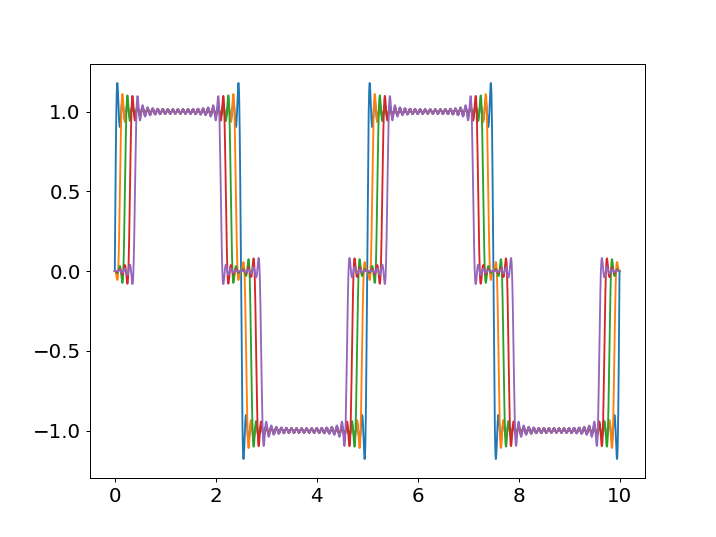

In [12]:
# Verify exact solution
%matplotlib notebook

import matplotlib.pyplot as plt
from numpy import sin, cos, pi, linspace, array
from scipy.integrate import quad

L = 10. # Define length of domain as a global variable
k = 100 # Number of terms in the Fourier sine series

def square_init(x): # Square function to base Fourier series off of
    if x >= 0 and x < L/4.:
        return 1.
    elif x >= L/4. and x < L/2.:
        return -1.
    else:
        return 0.

def D_n_inner(x, n): # Inner part of D_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(n*pi*x/L)
    
def D_n_calc(n): # Define function to calculate d_n for a given n
    if n % 2 == 0:
        return (4./L)*quad(D_n_inner, 0, L/2., args=(n))[0]
    else:
        return 0.

def u(x, t): # Analytic solution calculator
    u_temp = 0.
    
    for n in range(1, 2*k+1):
        u_temp += D_n_calc(n)*sin(n*pi*x/L)*cos(n*pi*t/L)
        
    return u_temp


x_vals = linspace(0, L, 2001)
fig = plt.figure()
for t in range(5):
    u_vals = u(x_vals, t/10)
    plt.plot(x_vals, u_vals)
plt.show()

Operator `Kernel` run in 0.00 s


<IPython.core.display.Javascript object>


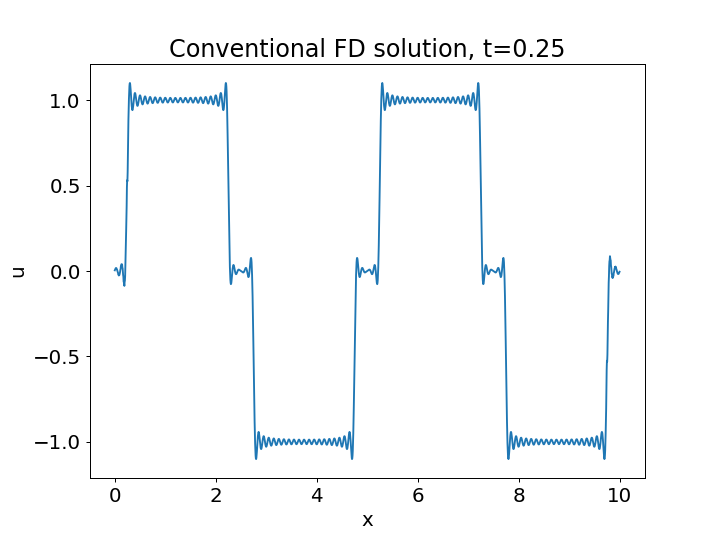

<IPython.core.display.Javascript object>


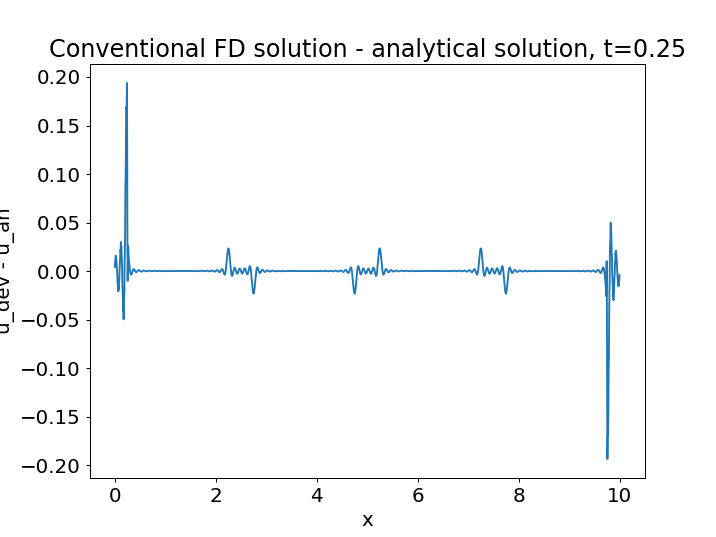

In [24]:
# Conventional FD solution using Devito stencil

#from numpy import shape
from devito import TimeFunction, Grid, SpaceDimension, Operator, Constant, Eq
from sympy import solve, init_printing, latex
init_printing(use_latex=True)

so = 6 # 6th order accurate in space
to = 2 # 2nd order accurate in time

extent = (L,)
# Grid is L long with 201 grid points
shape = (2001,)

dt = 0.5*(L/(shape[0]-1)) # Timestep is half critical dt (0.0025)

# Define x and z as spatial dimentions for Sympy
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x,))

u_dev = TimeFunction(name="u_dev", grid=grid, space_order=so, time_order=to) #, staggered=x

#u_dev.data.shape
#u_dev.forward

#pde = solve(u_dev.dx2 - u_dev.dt2, u_dev.forward)
#stencil = Eq(u_dev.forward, (dt**2)*u_dev.dx2 + 2.*u_dev - u_dev.backward )
stencil_dev = Eq(u_dev.forward, solve(u_dev.dx2 - u_dev.dt2, u_dev.forward)[0])

# Set initial field equal to u(x, 0)

def b_n_inner(x, n): # Inner part of b_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(2.*n*pi*x/L)

def b_n_calc(n):
    return (4./L)*quad(b_n_inner, 0, L/2., args=(n))[0]
    
def u_init(x):
    u_temp = 0.
    for n in range(1, k+1):
        u_temp += b_n_calc(n)*sin(2.*n*pi*x/L)
        
    return u_temp


u_dev.data[:] = u_init(linspace(0, L, u_dev.data.shape[1]))

op_dev = Operator([stencil_dev])
op_dev(time=100, dt=dt)

fig = plt.figure()
plt.plot(x_vals, u_dev.data[1])
plt.title("Conventional FD solution, t=0.25")
plt.xlabel("x")
plt.ylabel("u")
plt.show()


fig = plt.figure()
plt.plot(x_vals, u_dev.data[1]-u(x_vals, 100*dt))
plt.title("Conventional FD solution - analytical solution, t=0.25")
plt.xlabel("x")
plt.ylabel("u_dev - u_an")
plt.show()

In [ ]:
# Difference in FFT?